# DMLIV (Double ML for IVs)

**Scenario**

This study examines the causal impact of a personalized health coaching program on patient wellness outcomes.

*   **Treatment (T):** Level of engagement in the coaching program, measured by the number of sessions attended.
*   **Outcome (Y):** Improvement in wellness scores after six months.
*   **Covariates (X):**
    *   **X₀:** Baseline health risk
    *   **X₁:** Physical activity level
    *   **X₂:** Dietary quality
*   **Additional Controls (W):**
    *   **W₀:** Stress level
    *   **W₁:** Sleep quality  
    Stress and sleep quality can affect both program engagement and wellness outcomes. Including W in the model improves precision and helps satisfy assumptions for causal inference. These controls capture other health-related factors that may influence both treatment engagement and wellness outcomes, helping reduce omitted variable bias.

**Endogeneity:**  
Patients with higher baseline risk (X₀) tend to attend more sessions and may have unobserved motivation that independently improves wellness, creating correlation between T and the error term in the outcome equation. Naive OLS estimates would therefore be biased.

**Instrumental Variable (Z):**  
Random assignment to receive motivational text reminders. This instrument influences program participation but has no direct effect on wellness scores except through treatment engagement.


In [7]:
!pip install --upgrade econml

In [128]:
import numpy as np
import pandas as pd

true_effect = 2.0
np.random.seed(42)
n = 5000

# Generate covariates (X) and controls (W)
X = np.random.normal(0, 1, (n, 3))   # Covariates: Baseline, Activity, Dietary
W = np.random.normal(0, 1, (n, 2))   # Controls: Stress, Sleep Quality

# Instrument
Z = np.random.binomial(1, 0.5, size=n)  # Instrument: motivational text reminders

# Treatment: influenced by instrument and baseline health risk
T = 0.5 * Z + 1.5 * X[:, 0] + np.random.normal(0, 1, size=n)

# Outcome: depends on treatment, activity, and error correlated with baseline
error_Y = np.random.normal(0, 1, size=n) + 0.8 * X[:, 0]
Y = true_effect * T + 0.5 * X[:, 1] + error_Y

# Create DataFrame with descriptive column names
df_hd = pd.DataFrame({
    'Baseline': X[:, 0],          # Baseline health risk
    'Activity': X[:, 1],          # Physical activity level
    'Dietary': X[:, 2],           # Dietary quality
    'Stress': W[:, 0],            # Stress level
    'SleepQuality': W[:, 1],      # Sleep quality
    'Treatment': T,               # Coaching program engagement
    'Outcome': Y,                 # Wellness improvement
    'Instrument': Z               # Motivational text reminders
})

print("Updated DataFrame with W included (first 5 rows):")
print(df_hd.head())

Updated DataFrame with W included (first 5 rows):
   Baseline  Activity   Dietary    Stress  SleepQuality  Treatment   Outcome  \
0  0.496714 -0.138264  0.647689 -0.143423     -0.032656   1.534911  2.931539   
1  1.523030 -0.234153 -0.234137  0.064295      0.946861   1.592548  3.841512   
2  1.579213  0.767435 -0.469474 -0.747217     -0.846347   1.549821  5.751520   
3  0.542560 -0.463418 -0.465730  1.236620     -0.462645   2.237177  5.688446   
4  0.241962 -1.913280 -1.724918 -1.263035     -0.485130   2.239843  3.870045   

   Instrument  
0           1  
1           1  
2           0  
3           1  
4           0  


## DAG

/var/folders/b8/hq7p21n142n321y966q8j1600000gn/T/ipykernel_1455/715117355.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


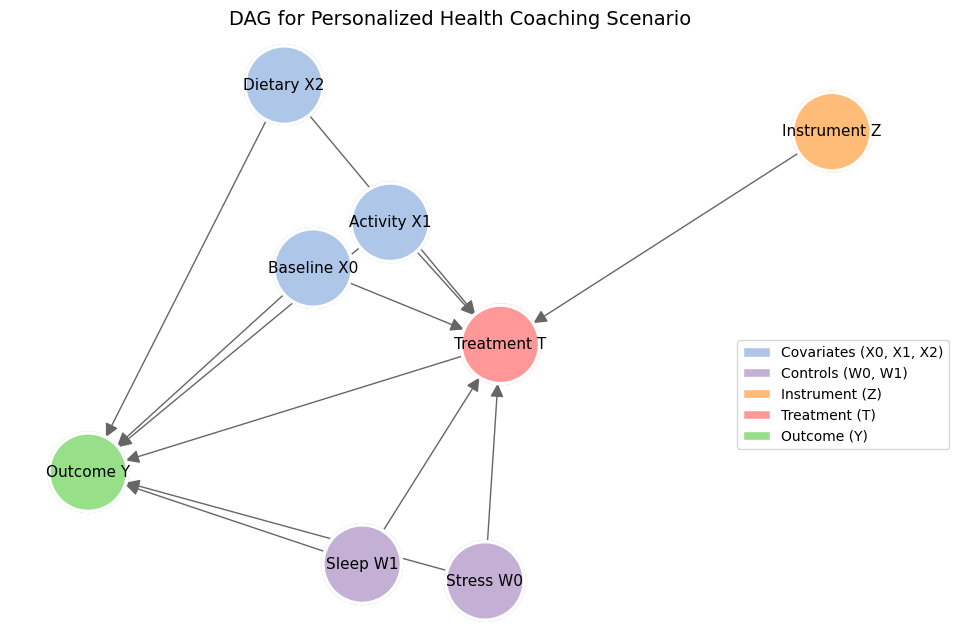

In [138]:

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Create directed graph
G = nx.DiGraph()

# Nodes
nodes = ["Instrument Z", "Treatment T", "Outcome Y","Baseline X0", "Activity X1", "Dietary X2", "Stress W0", "Sleep W1",
         ]
G.add_nodes_from(nodes)

# Edges
edges = [
    ("Instrument Z", "Treatment T"),
    ("Baseline X0", "Treatment T"),
    ("Activity X1", "Treatment T"),
    ("Dietary X2", "Treatment T"),
    ("Stress W0", "Treatment T"),
    ("Sleep W1", "Treatment T"),
    ("Baseline X0", "Outcome Y"),
    ("Treatment T", "Outcome Y"),
    ("Activity X1", "Outcome Y"),
    ("Dietary X2", "Outcome Y"),
    ("Stress W0", "Outcome Y"),
    ("Sleep W1", "Outcome Y")
]
G.add_edges_from(edges)

# Colors by category
node_colors_map = {
    "Baseline X0": "#aec7e8", "Activity X1": "#aec7e8", "Dietary X2": "#aec7e8",  # Covariates
    "Stress W0": "#c5b0d5", "Sleep W1": "#c5b0d5",                                # Controls
    "Instrument Z": "#ffbb78",                                                    # Instrument
    "Treatment T": "#ff9896",                                                    # Treatment
    "Outcome Y": "#98df8a",                                                      # Outcome
}
color_list = [node_colors_map[n] for n in G.nodes()]

plt.figure(figsize=(9, 6))
pos = nx.spring_layout(G, seed=42)

nx.draw(G, pos, with_labels=True, node_size=3200, node_color=color_list,
        font_size=11, #font_weight='bold', 
        arrowsize=20, edge_color="#666666", linewidths=2.5)

nx.draw_networkx_nodes(G, pos, node_size=3200, node_color=color_list,
                       edgecolors='white', linewidths=2.5)

plt.title("DAG for Personalized Health Coaching Scenario", fontsize=14)

# Legend
legend_labels = {
    "Covariates (X0, X1, X2)": "#aec7e8",
    "Controls (W0, W1)": "#c5b0d5",
    "Instrument (Z)": "#ffbb78",
    "Treatment (T)": "#ff9896",
    "Outcome (Y)": "#98df8a"
}
legend_patches = [Patch(facecolor=color, edgecolor='white', label=label) for label, color in legend_labels.items()]
plt.legend(handles=legend_patches, bbox_to_anchor=(0.8, 0.5), loc='upper left')

plt.tight_layout()
plt.show()

## A Naive OLS

In [126]:
import numpy as np
import statsmodels.api as sm

# 2. Naive OLS regression of Y on T (ignoring endogeneity)
X_ols = sm.add_constant(T)
ols_model = sm.OLS(Y, X_ols).fit()

# 3. Print results
estimated_effect = ols_model.params[1]
print("True Effect:", true_effect)
print("Naive OLS Estimated Effect:", estimated_effect)
print("OLS Summary:\n", ols_model.summary())

True Effect: 2.0
Naive OLS Estimated Effect: 2.3493219183421994
OLS Summary:
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 6.507e+04
Date:                Wed, 03 Dec 2025   Prob (F-statistic):               0.00
Time:                        14:56:17   Log-Likelihood:                -8017.6
No. Observations:                5000   AIC:                         1.604e+04
Df Residuals:                    4998   BIC:                         1.605e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

## DoWhy IV (2SLS) Implementation

In [129]:
import dowhy
from dowhy import CausalModel

# Define the causal model using updated DataFrame and column names
model_iv = CausalModel(
    data=df_hd,
    treatment='Treatment',          # Updated treatment column
    outcome='Outcome',              # Updated outcome column
    instruments='Instrument',       # Updated instrument column
    common_causes=['Baseline', 'Activity', 'Dietary', 'Stress', 'SleepQuality'] 
)

# Identify the estimand
identified_estimand = model_iv.identify_effect(proceed_when_unidentifiable=True)

# Estimate effect using IV (2SLS)
est_iv = model_iv.estimate_effect(
    identified_estimand,
    method_name="iv.instrumental_variable"
)

print("DoWhy IV (2SLS) estimate:", est_iv.value)

DoWhy IV (2SLS) estimate: 2.01192452325311


## EconML DMLIV Implementation

In [130]:
from econml.iv.dml import DMLIV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neural_network import MLPRegressor

# Define different model configurations
models = {
    "Linear": {
        "model_y_xw": LinearRegression(),
        "model_t_xw": LinearRegression(),
        "model_t_xwz": LinearRegression()
    },
    "RandomForest": {
        "model_y_xw": RandomForestRegressor(n_estimators=100, max_depth=5),
        "model_t_xw": RandomForestRegressor(n_estimators=100, max_depth=5),
        "model_t_xwz": RandomForestRegressor(n_estimators=100, max_depth=5)
    },
    "GradientBoosting": {
        "model_y_xw": GradientBoostingRegressor(n_estimators=100),
        "model_t_xw": GradientBoostingRegressor(n_estimators=100),
        "model_t_xwz": GradientBoostingRegressor(n_estimators=100)
    },
    "Lasso": {
        "model_y_xw": Lasso(alpha=0.01),
        "model_t_xw": Lasso(alpha=0.01),
        "model_t_xwz": Lasso(alpha=0.01)
    },
    "NeuralNet": {
        "model_y_xw": MLPRegressor(hidden_layer_sizes=(50,), max_iter=500),
        "model_t_xw": MLPRegressor(hidden_layer_sizes=(50,), max_iter=500),
        "model_t_xwz": MLPRegressor(hidden_layer_sizes=(50,), max_iter=500)
    }
}

# Fit each model and store CATE estimates
cate_results = {}
for name, m in models.items():
    dmliv = DMLIV(
        model_y_xw=m["model_y_xw"],
        model_t_xw=m["model_t_xw"],
        model_t_xwz=m["model_t_xwz"],
        model_final=LinearRegression(),
        discrete_treatment=False
    )
    dmliv.fit(Y=Y, T=T, Z=Z, X=X, W=W)
    cate_results[name] = dmliv.effect(X)
    print(f"{name} (first 10 CATE):", cate_results[name][:10])


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/econml/dml/dml.py:192: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  warn("The final model has a nonzero intercept for at least one outcome; "


Linear (first 10 CATE): [1.702484   1.48401605 1.5558492  1.89303106 2.19287511 2.13208907
 2.01473491 2.40195285 2.47039982 1.91537744]


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/econml/dml/dml.py:192: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  warn("The final model has a nonzero intercept for at least one outcome; "


RandomForest (first 10 CATE): [2.12848318 2.34880739 2.42768669 2.21906322 2.2177419  1.96472153
 1.79217224 2.22264763 2.154927   2.17289621]


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/econml/dml/dml.py:192: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  warn("The final model has a nonzero intercept for at least one outcome; "


GradientBoosting (first 10 CATE): [1.5367837  1.36868715 1.50244815 1.61895654 1.67212492 1.74191187
 1.64487836 1.99298696 2.04680283 1.62431697]


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/econml/dml/dml.py:192: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  warn("The final model has a nonzero intercept for at least one outcome; "


Lasso (first 10 CATE): [1.82149969 1.56777499 1.67749457 2.01438313 2.29234846 2.26984143
 2.13595348 2.59031859 2.67021234 2.03638529]
NeuralNet (first 10 CATE): [1.27479134 1.1183568  1.21612718 1.29666227 1.28558128 1.41222389
 1.37647458 1.54716675 1.59702867 1.30583141]


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/econml/dml/dml.py:192: UserWarning: The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
  warn("The final model has a nonzero intercept for at least one outcome; "


True Effect: 2.0
Linear: mean=2.028, std=0.427
RandomForest: mean=2.123, std=0.178
GradientBoosting: mean=1.758, std=0.304
Lasso: mean=2.183, std=0.476
NeuralNet: mean=1.419, std=0.220


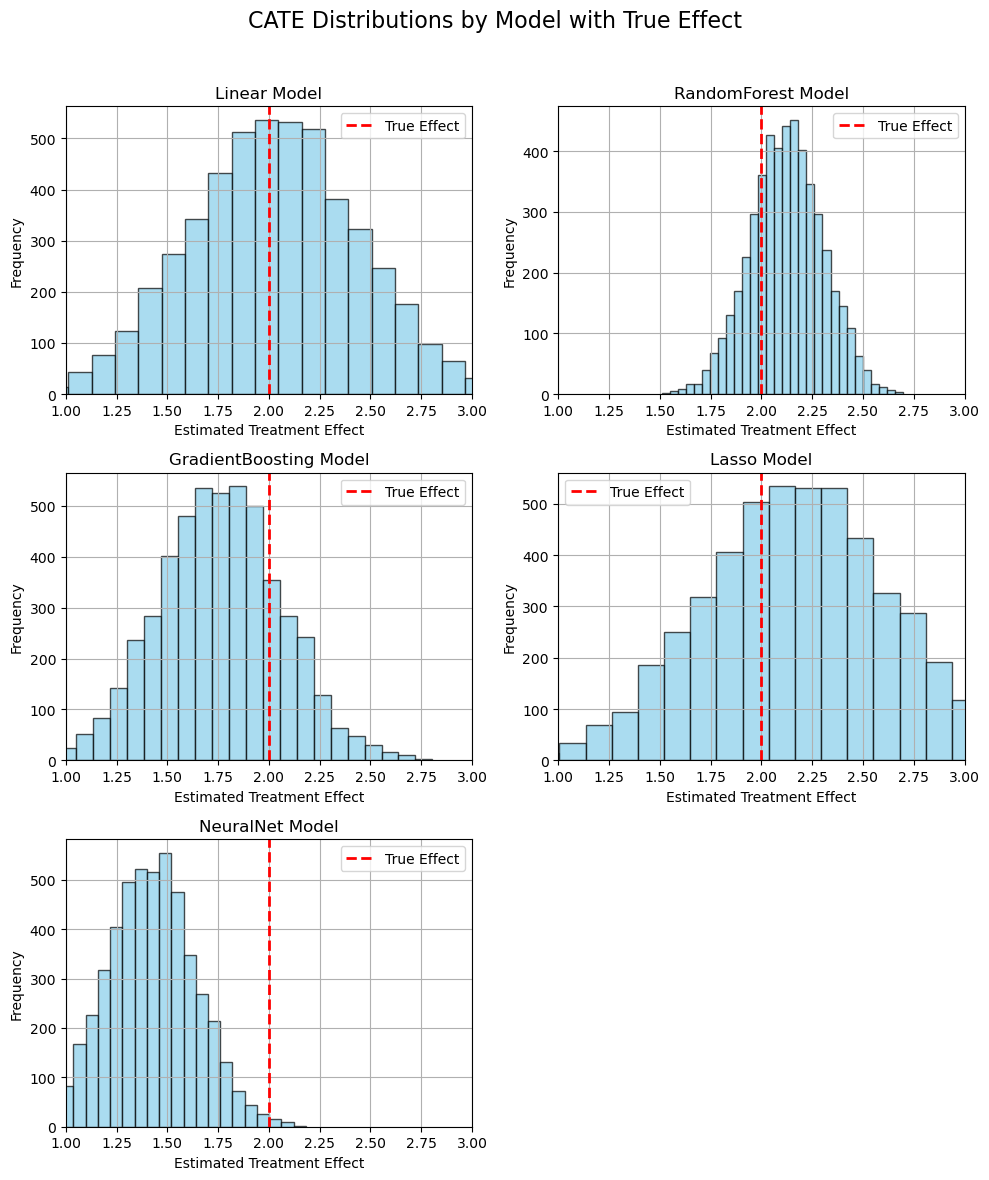

In [131]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
fig.suptitle('CATE Distributions by Model with True Effect', fontsize=16)

axes = axes.flatten()

for i, (name, cate) in enumerate(cate_results.items()):
    axes[i].hist(cate, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].axvline(x=true_effect, color='red', linestyle='--', linewidth=2, label='True Effect')
    axes[i].set_title(f'{name} Model')
    axes[i].set_xlim(1,3)
    axes[i].set_xlabel('Estimated Treatment Effect')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True)

# Hide the last empty subplot if models < 6
if len(cate_results) < len(axes):
    axes[-1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('cate_histograms_3x2.png')

# Print summary statistics for each model
print("True Effect:", true_effect)
for name, cate in cate_results.items():
    print(f"{name}: mean={np.mean(cate):.3f}, std={np.std(cate):.3f}")


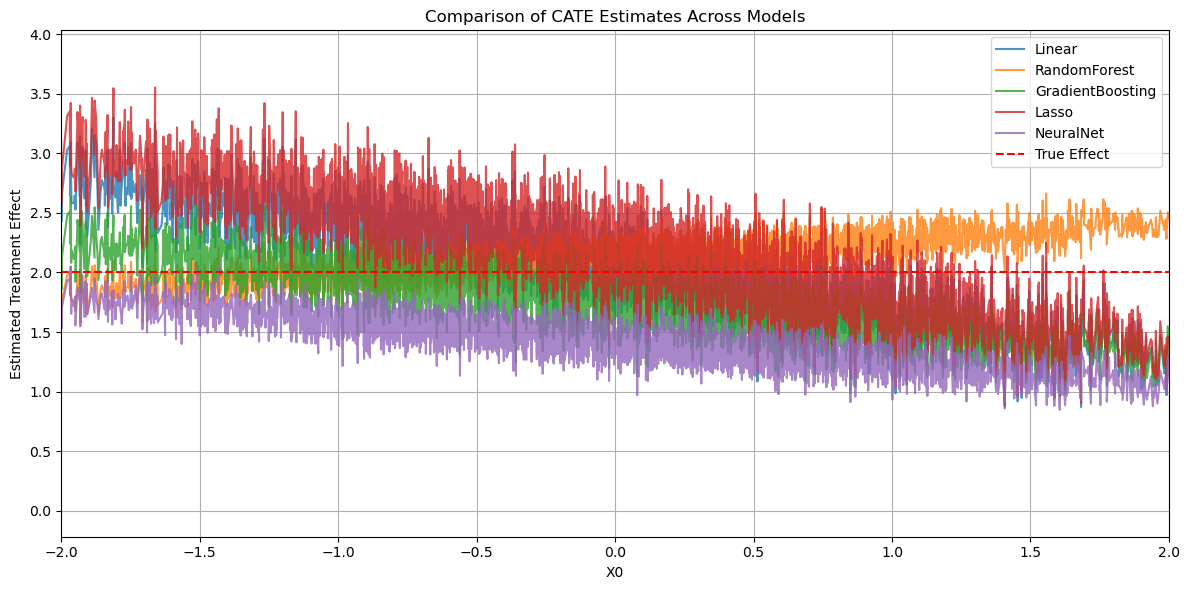

In [132]:
# Visualization: Compare all models vs X1
sorted_idx = np.argsort(X[:, 0])
X1_sorted = X[:, 0][sorted_idx]

plt.figure(figsize=(12, 6))
for name, cate in cate_results.items():
    plt.plot(X1_sorted, cate[sorted_idx], label=name, alpha=0.8)
plt.axhline(y=2.0, color='red', linestyle='--', label='True Effect')
plt.xlabel('X0')
plt.ylabel('Estimated Treatment Effect')
plt.title('Comparison of CATE Estimates Across Models')
plt.legend()
plt.xlim(-2,2)
plt.grid(True)
plt.tight_layout()
plt.show()

**What the Plot Shows**

*   **True Effect (Red dashed line)**: The true treatment effect is constant at 2.0.
*   **Linear Model (Blue)**: Stays close to the true effect with minimal variation, as expected because linear models impose strong structure.
*   **RandomForest (Orange)**: Shows moderate variability but generally hovers near the true effect.
*   **GradientBoosting (Green)**: Highly volatile and often underestimates the effect, especially for higher values of ( X\_1 ). This suggests instability and overfitting.
*   **Lasso (Purple)**: Consistently underestimates the effect (around 1.2–1.5), due to regularization shrinking coefficients.
*   **NeuralNet (Red solid)**: Overestimates the effect across most of the range (often above 2.5 and up to 3.5), indicating strong bias and instability.

**Why Some Are Very Off**

1.  **NeuralNet**: Neural networks require large samples and careful tuning. With limited data and no hyperparameter optimization, they overfit and produce inflated estimates.
2.  **GradientBoosting**: Flexible but sensitive to noise and sample size, leading to erratic CATE estimates.
3.  **Lasso**: Regularization introduces downward bias, shrinking estimates toward zero.
4.  **Bias-Variance Tradeoff**: Complex models (NeuralNet, GradientBoosting) have high variance and can mislead interpretation of heterogeneity when the true effect is constant.